# Purple_CCF calculation in melanoma sample

In [2]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from matplotlib_venn import venn3
import time

In [3]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [4]:
# Import filtered mutation files 
common_mut_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_List_common_mutations_callers.tsv.gz', sep="\t", header=0)

# Import purity value
purple_purity_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp1/purple/AB9767.purple.purity.tsv', sep="\t", header=0)
purple_cnv_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp1/purple/AB9767.purple.cnv.somatic.tsv', sep="\t", header=0)

In [5]:
common_mut_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,69,11,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,65,10,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,106,10,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,153,13,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,155,22,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A


In [6]:
# Extract purity value from table, note that this value is the Aberrant Cell Fraction
purity = purple_purity_df['purity']
purity

0    0.24
Name: purity, dtype: float64

## 1/ Processing CNV file

In [7]:
purple_cnv_df.head()

,chromosome,start,end,copyNumber,bafCount,observedBAF,baf,segmentStartSupport,segmentEndSupport,method,depthWindowCount,gcContent,minStart,maxStart,minorAlleleCopyNumber,majorAlleleCopyNumber
0,chr1,1,5387177,2.1056,3731,0.5311,0.5260,TELOMERE,DUP,BAF_WEIGHTED,2805,0.5218,1,1,0.9980,1.1076
1,chr1,5387178,5387398,3.5654,0,0.0000,0.7201,DUP,DUP,STRUCTURAL_VARIANT,0,0.0000,5387178,5387178,0.9980,2.5674
2,chr1,5387399,6522858,2.0808,571,0.5283,0.5191,DUP,DEL,BAF_WEIGHTED,941,0.5195,5387399,5387399,1.0007,1.0801
3,chr1,6522859,6522895,1.1162,0,0.0000,0.8825,DEL,DEL,STRUCTURAL_VARIANT,0,0.0000,6522859,6522859,0.1312,0.9851
4,chr1,6522896,102957859,2.0363,59515,0.5320,0.5162,DEL,DEL,BAF_WEIGHTED,89105,0.4222,6522896,6522896,0.9851,1.0512


In [8]:
# Purple CNV file has information of copy number calculated, it is the copyNumber column and is the sum of minorAlleleCopyNumber and majorAlleleCopyNumber

purple_cnv_df = purple_cnv_df[['chromosome','start','end','copyNumber']] # select columns of interest
purple_cnv_df = purple_cnv_df.rename(columns={'chromosome':'chrom','copyNumber':'CN'})

In [9]:
# # Calculate copy number (CN) from cnv files and add it as new column 
purple_cnv_df[['CN']] = purple_cnv_df[['CN']].astype(float) # convert so it is float, if not it converts it to integer/object


## 2/ Add CN to common mutations df

### 2.1 Try to obtain CN with a function

In [10]:
# def get_cn (row):
#     mut = row['CHROM']
#     startpos = ascat_cnv_df['startpos']
#     endpos = ascat_cnv_df['endpos']
#     cnv = ascat_cnv_df['CN']
#     for row in common_mut_df.iterrows():
#         if mut >= startpos & mut <= endpos:
#             CNV = row(cnv)
#             break
#     return CNV

# common_mut_df['CN'] = common_mut_df.progress_apply(lambda row: get_cn(row),axis=1)

def get_cn(row, ascat_cnv_df):
    mut = int(row['CHROM'])  # Convert CHROM to integer
    for index, ascat_row in ascat_cnv_df.iterrows():
        startpos = int(ascat_row['startpos'])  # Convert startpos to integer
        endpos = int(ascat_row['endpos'])  # Convert endpos to integer
        cnv = ascat_row['CN']
        if mut >= startpos and mut <= endpos:
            return cnv
    return None

common_mut_df['CN'] = common_mut_df.apply(lambda row: get_cn(row, ascat_cnv_df), axis=1)



NameError: name 'ascat_cnv_df' is not defined

In [ ]:
def get_cn (row):
    chrom = row['CHROM']
    cnv_df = cnv_rhab[cnv_rhab['chrom']==chrom]
    for row2 in cnv_df.iterrows():
        startpos = row2[1]['startpos']
        endpos = row2[1]['endpos']
        mutpos = row['POS']
        if mutpos >= startpos & mutpos < endpos:
            cn = row2[1]['CN']
            break
            
        # break
        # cn = None
    
    return cn

vaf_rhab['CN'] = vaf_rhab.progress_apply(lambda row: get_cn(row),axis=1)
vaf_rhab

### 2.2 Obtain CN with Pybedtools

In [10]:
# Pybedtools package: see https://daler.github.io/pybedtools/main.html for documentation
 
# installed in melos conda environment through terminal with: pip install pybedtools

# Now import the library

import pybedtools

# Note that the path of BedTools has been modified in bashrc file to be able to execute pybedtools.

In [11]:
# To use pybedtools POS column of common_mut_df should have another coordenate like end position. To do so, duplicate the information of POS column

mutations_df = pd.DataFrame({
    'CHROM': common_mut_df['CHROM'],
    'start': common_mut_df['POS'],
    'end': common_mut_df['POS'] + 1, # duplicate this column so it is considered a "bed file"
    'REF': common_mut_df['REF'],
    'ALT': common_mut_df['ALT']
    
})

mutations_df

,CHROM,start,end,REF,ALT
0,chr1,59074,59075,C,T
1,chr1,60739,60740,G,A
2,chr1,86292,86293,C,T
3,chr1,108632,108633,C,T
4,chr1,115638,115639,G,A
...,...,...,...,...,...
1062268,chrY,56824933,56824934,C,T
1062269,chrY,56825646,56825647,G,A
1062270,chrY,56846085,56846086,C,T
1062271,chrY,56846554,56846555,G,A


In [12]:
# Convert dataframes to a BedTool object so it could be processed with pybedtools
mutations_bt = pybedtools.BedTool.from_dataframe(mutations_df)
purple_cnv_bt = pybedtools.BedTool.from_dataframe(purple_cnv_df)

In [13]:
# Use intersect method of Bedtools to intersect (see https://daler.github.io/pybedtools/intersections.html)
cnv_bt = purple_cnv_bt.intersect(mutations_bt) #save intersect table into a new dataframe

In [14]:
# Convert cnv bedtool object into a dataframe. 
cnv_df = cnv_bt.to_dataframe(header=None) # Note that "chrom, start, end, name" columns are by default even using "header = None".

In [15]:
# Rename columns of cnv dataframe
cnv_df = cnv_df.rename(columns={'chrom':'CHROM','start':'POS','end':'POS2','name':'CN'})

# Drop POS2 column, which is an artificial column we created previously
cnv_df = cnv_df.drop(columns='POS2')

In [16]:
# We are loosing this number of mutations with the intersect method (?!)
len(mutations_df) - len(cnv_df)

3

In [17]:
cnv_df.head()

,CHROM,POS,CN
0,chr1,59074,2.1056
1,chr1,60739,2.1056
2,chr1,86292,2.1056
3,chr1,108632,2.1056
4,chr1,115638,2.1056


## 3/ Calculate CCF

In [18]:
# Merge intersect with common_mut_df adding left indicates: use only keys from left frame, preserve key order
mutations_cnv_df = pd.merge(common_mut_df,cnv_df,how='left')

In [19]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,11,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T,2.1056
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,10,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A,2.1056
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,10,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T,2.1056
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,13,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T,2.1056
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,22,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A,2.1056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062270,chrY,56824933,.,C,T,293,PASS,LPS=428319;LPS_RC=9;RC=TCTTTA;RC_IDX=2;RC_LF=T...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:518,0:0:518:16364,0:539,0:0,0,0,0,0,518,...",...,16,0,399,518,0.039000,SNV,Mutect_SAGE,melanoma,chrY_56824933_C_T,1.0305
1062271,chrY,56825646,.,G,A,454,PASS,LPS=428320;LPS_RC=4;RC=GAAAGC;RC_IDX=3;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:430,0:0:430:13675,0:443,0:0,0,0,0,0,430,...",...,16,0,362,430,0.042000,SNV,Mutect_SAGE,melanoma,chrY_56825646_G_A,1.0305
1062272,chrY,56846085,.,C,T,558,PASS,RC=CTTTG;RC_IDX=2;RC_LF=TTTTTCTACC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:33:599,1:0.001667:600:18877,0:615,0:0,0,1,...",...,21,1,500,599,0.040000,SNV,Mutect_SAGE,melanoma,chrY_56846085_C_T,1.0305
1062273,chrY,56846554,.,G,A,305,PASS,RC=AGATG;RC_IDX=2;RC_LF=CTGATCACAC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:9:662,1:0.001508:663:20164,9:683,1:1,0,0,0...",...,14,1,513,662,0.027000,SNV,Mutect_SAGE,melanoma,chrY_56846554_G_A,1.0305


In [20]:
# Check in CN column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
nan_values = mutations_cnv_df[~mutations_cnv_df['CN'].isna()]

In [21]:
# Add 2 in CN with NaN values, because these positions despite were not in the cnv file are diploid
mutations_cnv_df['CN'].fillna(2, inplace=True) 
# Convert columns to float so they are operable to calculate CCF
mutations_cnv_df[['VAF','CN']] = mutations_cnv_df[['VAF','CN']].astype(float)

In [22]:
def get_ccf(row):
    row = row['VAF'] * (purity * row['CN'] + (1 - purity) * 2) / purity
    return row

mutations_cnv_df['CCF'] = mutations_cnv_df.progress_apply(get_ccf, axis=1)

  0%|          | 0/1062275 [00:00<?, ?it/s]

In [23]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T,2.1056,3.200975
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A,2.1056,1.834551
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T,2.1056,0.992816
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T,2.1056,1.523696
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A,2.1056,1.181451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062270,chrY,56824933,.,C,T,293,PASS,LPS=428319;LPS_RC=9;RC=TCTTTA;RC_IDX=2;RC_LF=T...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:518,0:0:518:16364,0:539,0:0,0,0,0,0,518,...",...,0,399,518,0.039000,SNV,Mutect_SAGE,melanoma,chrY_56824933_C_T,1.0305,0.287189
1062271,chrY,56825646,.,G,A,454,PASS,LPS=428320;LPS_RC=4;RC=GAAAGC;RC_IDX=3;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:430,0:0:430:13675,0:443,0:0,0,0,0,0,430,...",...,0,362,430,0.042000,SNV,Mutect_SAGE,melanoma,chrY_56825646_G_A,1.0305,0.309281
1062272,chrY,56846085,.,C,T,558,PASS,RC=CTTTG;RC_IDX=2;RC_LF=TTTTTCTACC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:33:599,1:0.001667:600:18877,0:615,0:0,0,1,...",...,1,500,599,0.040000,SNV,Mutect_SAGE,melanoma,chrY_56846085_C_T,1.0305,0.294553
1062273,chrY,56846554,.,G,A,305,PASS,RC=AGATG;RC_IDX=2;RC_LF=CTGATCACAC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:9:662,1:0.001508:663:20164,9:683,1:1,0,0,0...",...,1,513,662,0.027000,SNV,Mutect_SAGE,melanoma,chrY_56846554_G_A,1.0305,0.198824


In [24]:
# BE CAREFUL, THE NUMBER OF ROWS HAS INCREASED FROM PREVIOUS TABLES, IT IS POSSIBLE THAT THERE ARE DUPLICATED ROWS!
# Just in case, apply this function to drop duplicated rows according to CHROM, POS, REF, ALT columns
mutations_cnv_df = mutations_cnv_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'])

In [25]:
# See that there were 2 rows duplicated!
mutations_cnv_df.shape 

(1062273, 26)

In [26]:
# Export as new table
# Save this table as new table tsv.gz
mutations_cnv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_CCF_Purple_common_mutations.tsv.gz', sep ='\t', index=None, compression = "gzip")

## 4/ Histograms representing CCF

In [26]:
# # Check in CCF column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
# mutations_ccf_df = mutations_cnv_df[~mutations_cnv_df['CCF'].isna()]

In [28]:
ccf = mutations_cnv_df['CCF'].copy()  # Extract the 'CCF' column
ccf = pd.to_numeric(ccf, errors='coerce')  # Convert values to numeric, coerce errors

In [29]:
ccf

0          3.200975
1          1.834551
2          0.992816
3          1.523696
4          1.181451
             ...   
1062270    0.287189
1062271    0.309281
1062272    0.294553
1062273    0.198824
1062274    0.839477
Name: CCF, Length: 1062273, dtype: float64

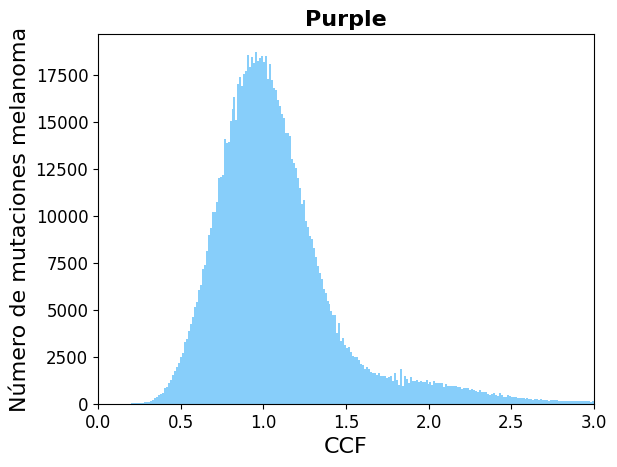

In [33]:
# Represent histogram without density plot

plt.hist(ccf.tolist(), bins = 500, color = "lightskyblue")
plt.xlim([0,3])
plt.ylabel('Número de mutaciones melanoma',fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('Purple',fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show(ccf.tolist())  

# Export image to directory
# plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_melanoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')

/tmp/jobs/efiguerola/9247450/ipykernel_17814/2878761438.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ccf, bins=200, color = 'dodgerblue')


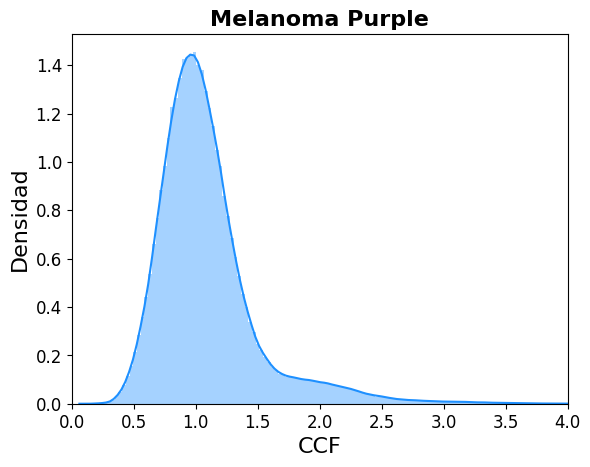

In [31]:
# Represent histogram with density plot to find the minimum 
ax = sns.distplot(ccf, bins=200, color = 'dodgerblue')
plt.title('Melanoma Purple', fontsize=16, weight='bold')
plt.xlim([0,4])
plt.xlabel('CCF', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Export image to directory
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_melanoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')